In [4]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:1


In [ ]:
# def true_2D_1(xt): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
#     y = xt[:,0]*np.cos(xt[:,1])
#     return y.reshape(-1,1)    

In [5]:
#Material Properties This link - https://www.mathworks.com/help/pde/ug/nonlinear-heat-transfer-in-a-thin-plate.html#heatTransferThinPlateExample-1
k = 400
rho = 8960
cp = 386
t_z = 0.01
stef_bolt = 5.670373e-8
hc = 1
Ta = 300
emiss = 0.5


In [6]:
label = "Navier_stan"

x = np.linspace(0,1,100).reshape(-1,1)
y = np.linspace(0,1,100).reshape(-1,1)
t = np.linspace(0,1,100).reshape(-1,1) #t is actually from 0 to 5000, let us scale it to 0 to 1

X,Y,T = np.meshgrid(x,y,t)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xyt = np.hstack((X,Y,T))

initial_pts = (T==0).reshape(-1,)

DBC_pts = np.logical_and(Y == 0,T != 0).reshape(-1,)


NBC_pts_1 = (X == 0).reshape(-1,)
#NBC_pts_2 = (Y == 0).reshape(-1,)
NBC_pts_3 = (X == 1).reshape(-1,)
NBC_pts_4 = (Y == 1).reshape(-1,)

xyt_initial = xyt[initial_pts,:]
xyt_DBC = xyt[DBC_pts,:]

xyt_NBC_1 = xyt[NBC_pts_1,:]
#xyt_NBC_2 = xyt[NBC_pts_2,:]
xyt_NBC_3 = xyt[NBC_pts_3,:]
xyt_NBC_4 = xyt[NBC_pts_4,:]

u_initial = np.zeros((np.shape(xyt_initial)[0],1))
u_DBC = 100*np.ones((np.shape(xyt_DBC)[0],1))

xyt_I_DBC = np.vstack((xyt_initial,xyt_DBC))
#xyt_NBC = np.vstack((xyt_NBC_1,xyt_NBC_2,xyt_NBC_3,xyt_NBC_4))
xyt_NBC = np.vstack((xyt_NBC_1,xyt_NBC_3,xyt_NBC_4))

u_I_DBC = np.vstack((u_initial,u_DBC))

xyt_test_tensor = torch.from_numpy(xyt).float().to(device)

lb_xyt = xyt[0]
ub_xyt = xyt[-1]

In [8]:
def trainingdata(N_D,N_N,N_f,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    
    #choose random N_u points for training
    idx = np.random.choice(xyt_I_DBC.shape[0], N_D, replace=False) 
    xyt_D = xyt_I_DBC[idx,:] #choose indices from  set 'idx' (x,t)
    u_D = u_I_DBC[idx].reshape(-1,1)      #choose corresponding u

    idx = np.random.choice(xyt_NBC.shape[0], N_D, replace=False) 
    xyt_N = xyt_NBC[idx,:] #choose indices from  set 'idx' (x,t)


    '''Collocation Points'''
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    
    xyt_coll = lb_xyt + (ub_xyt - lb_xyt)*samples
    xyt_coll = np.vstack((xyt_coll, xyt_D,xyt_N)) # append training points to collocation points 

    return xyt_coll, xyt_D, u_D, xyt_N

In [10]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        self.beta = Parameter(torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
        
        self.train_loss = []
        self.test_loss = []
        
        self.beta_val = []
        
        self.n = torch.tensor(1.0)
            
    'foward pass'
    def forward(self,xyt):
        if torch.is_tensor(xyt) != True:         
            xyt = torch.from_numpy(xyt)                
        
        ubxyt = torch.from_numpy(ub_xyt).float().to(device)
        lbxyt = torch.from_numpy(lb_xyt).float().to(device)
    
                      
        #preprocessing input 
        xyt = (xyt - lbxyt)/(ubxyt - lbxyt)
        
        #convert to float
        a = xyt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            z1 = self.activation(z) 
            a = z1 + self.beta[:,i]*z*z1
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_D(self,xyt_D,u_D):
                
        loss_bc = self.loss_function(self.forward(xyt_D), u_D)
                
        return loss_bc
    
    def loss_N(self,xyt_N,N_hat):
        
        g = xyt_N.clone()             
        g.requires_grad = True
        u = self.forward(g)
        
        u_x_y_t = autograd.grad(u,g,torch.ones([xyt_N.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du_dx = u_x_y_t[:,[0]]
        #du_dy = u_x_y_t[:,[1]]
        
        loss_N1 = self.loss_function(du_dx,N_hat)
        #loss_N2 = self.loss_function(du_dy,N_hat)
        
        #return loss_N1+loss_N2       
        return loss_N1
    
    def loss_PDE(self, xyt_coll, f_hat):
        
        g = xyt_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y_t = autograd.grad(u,g,torch.ones([xyt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy_tt = autograd.grad(u_x_y_t,g,torch.ones(xyt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        du_dt = u_x_y_t[:,[2]]
        
        d2u_dx2 = u_xx_yy_tt[:,[0]]
        d2u_dy2 = u_xx_yy_tt[:,[1]]    
        

        f = rho*cp*t_z*du_dt/5000 - k*t_z*(d2u_dx2+d2u_dy2) + 2*hc*(u-Ta) + 2*emiss*stef_bolt*(torch.pow(u,4)-Ta**4) 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xyt_D,u_D,xyt_N,N_hat,xyt_coll,f_hat):

        loss_D = self.loss_D(xyt_D,u_D)
        loss_N = self.loss_N(xyt_N,N_hat)
        loss_f = self.loss_PDE(xyt_coll,f_hat)
        
        loss_val = loss_D + loss_N + loss_f
        
        print(self.iter,"loss_D:",loss_D.cpu().detach().numpy(),"loss_N:",loss_N.cpu().detach().numpy(),"loss_f:",loss_f.cpu().detach().numpy())
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        optimizer.zero_grad()
        
        loss = self.loss(xyt_D,u_D,xyt_N,N_hat,xyt_coll,f_hat)
        self.train_loss.append(loss.cpu().detach().numpy())
        
        u_pred = self.test(xyt_test_tensor)
        #self.test_loss.append(np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))) #Commented because no true values yet
        self.beta_val.append(self.beta.cpu().detach().numpy())
        
        #print(self.iter,"Train Loss",self.train_loss[-1],"Test Loss",self.test_loss[-1])
        print(self.iter,"Train Loss",self.train_loss[-1])
        
        loss.backward()
        self.iter += 1
  

        return loss        
    'test neural network'
    def test(self,xyt_test_tensor):
        u_pred = self.forward(xyt_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

In [11]:
max_reps = 1

train_loss_full = []
test_loss_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))

for reps in range(max_reps):
    print(reps)
    
    torch.manual_seed(reps*36)
    N_D = 5000 #Total number of data points for 'y'
    N_N = 7000
    N_f = 10000 #Total number of collocation points 
    
    xyt_coll_np_array, xyt_D_np_array, u_D_np_array,xyt_N_np_array = trainingdata(N_D,N_N,N_f,(reps)*22)
        
    xyt_coll = torch.from_numpy(xyt_coll_np_array).float().to(device)
    xyt_D = torch.from_numpy(xyt_D_np_array).float().to(device)
    u_D = torch.from_numpy(u_D_np_array).float().to(device)
    xyt_N = torch.from_numpy(xyt_N_np_array).float().to(device)
        
    N_hat = torch.zeros(xyt_N.shape[0],1).to(device)    
    f_hat = torch.zeros(xyt_coll.shape[0],1).to(device)

    layers = np.array([3,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers
    #layers = np.array([3,100,100,100,100,100,100,100,1])

    PINN = Sequentialmodel(layers)
   
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                              max_iter = 10000, 
                              max_eval = None, 
                              tolerance_grad = -1, 
                              tolerance_change = -1, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')



    start_time = time.time()
        
    optimizer.step(PINN.closure)
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(PINN.train_loss)
    test_loss_full.append(PINN.test_loss)
    elapsed_time[reps] = time.time() - start_time
    beta_full.append(PINN.beta_val)


    print('Training time: %.2f' % (elapsed_time[reps]))
    
mdic = {"train_loss": train_loss_full,"test_loss": test_loss_full,"Time": elapsed_time, "beta": beta_full, "label": label}
savemat(label+'.mat', mdic)

0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0 loss_D: 5011.9497 loss_N: 0.9682867 loss_f: 1126743.5
0 Train Loss 1131756.4
1 loss_D: 5006.3994 loss_N: 0.95781577 loss_f: 1124402.5
1 Train Loss 1129409.9
2 loss_D: 4954.4526 loss_N: 0.79594314 loss_f: 1103841.6
2 Train Loss 1108796.9
3 loss_D: 4749.934 loss_N: 0.43729374 loss_f: 1092676.4
3 Tra

95 loss_D: 737.65216 loss_N: 9.618099 loss_f: 30.257118
95 Train Loss 777.5274
96 loss_D: 739.5584 loss_N: 9.528499 loss_f: 26.352537
96 Train Loss 775.43945
97 loss_D: 737.0006 loss_N: 9.947508 loss_f: 26.87848
97 Train Loss 773.8266
98 loss_D: 737.4002 loss_N: 9.866598 loss_f: 25.813677
98 Train Loss 773.08044
99 loss_D: 738.0699 loss_N: 9.848575 loss_f: 24.470108
99 Train Loss 772.38855
100 loss_D: 737.0628 loss_N: 9.694911 loss_f: 24.226364
100 Train Loss 770.9841
101 loss_D: 730.82477 loss_N: 9.1466255 loss_f: 26.087482
101 Train Loss 766.05884
102 loss_D: 729.00464 loss_N: 8.97853 loss_f: 26.038885
102 Train Loss 764.02203
103 loss_D: 722.9642 loss_N: 8.994208 loss_f: 27.825663
103 Train Loss 759.78406
104 loss_D: 718.11786 loss_N: 9.029224 loss_f: 29.612675
104 Train Loss 756.75977
105 loss_D: 715.79016 loss_N: 9.113309 loss_f: 29.82219
105 Train Loss 754.72565
106 loss_D: 713.6181 loss_N: 9.080404 loss_f: 30.359238
106 Train Loss 753.05774
107 loss_D: 713.72107 loss_N: 9.053056

198 loss_D: 589.6286 loss_N: 24.539215 loss_f: 17.754147
198 Train Loss 631.922
199 loss_D: 589.26855 loss_N: 24.539793 loss_f: 17.55319
199 Train Loss 631.3615
200 loss_D: 588.80115 loss_N: 24.694515 loss_f: 17.170868
200 Train Loss 630.6665
201 loss_D: 587.98376 loss_N: 25.100138 loss_f: 16.701752
201 Train Loss 629.78564
202 loss_D: 587.3376 loss_N: 25.6867 loss_f: 15.887297
202 Train Loss 628.91156
203 loss_D: 584.5998 loss_N: 26.832619 loss_f: 17.258312
203 Train Loss 628.69073
204 loss_D: 585.5285 loss_N: 26.451855 loss_f: 15.994996
204 Train Loss 627.97534
205 loss_D: 585.62756 loss_N: 26.007425 loss_f: 16.003819
205 Train Loss 627.63885
206 loss_D: 584.9002 loss_N: 26.0238 loss_f: 16.271923
206 Train Loss 627.1959
207 loss_D: 582.9868 loss_N: 26.129684 loss_f: 17.347952
207 Train Loss 626.4645
208 loss_D: 582.74805 loss_N: 26.138868 loss_f: 17.117647
208 Train Loss 626.0046
209 loss_D: 582.3172 loss_N: 25.752058 loss_f: 16.770786
209 Train Loss 624.8401
210 loss_D: 582.6307 los

300 loss_D: 524.924 loss_N: 21.650059 loss_f: 15.86992
300 Train Loss 562.44403
301 loss_D: 524.9981 loss_N: 21.60551 loss_f: 15.435931
301 Train Loss 562.03955
302 loss_D: 524.9096 loss_N: 21.571411 loss_f: 14.795371
302 Train Loss 561.27637
303 loss_D: 523.9839 loss_N: 21.488993 loss_f: 14.862462
303 Train Loss 560.3354
304 loss_D: 523.3606 loss_N: 21.481047 loss_f: 14.619806
304 Train Loss 559.4614
305 loss_D: 521.9624 loss_N: 21.675522 loss_f: 15.24166
305 Train Loss 558.8796
306 loss_D: 521.33 loss_N: 21.635395 loss_f: 15.306079
306 Train Loss 558.2715
307 loss_D: 519.97156 loss_N: 21.760466 loss_f: 16.195393
307 Train Loss 557.92737
308 loss_D: 520.16705 loss_N: 21.570305 loss_f: 15.897837
308 Train Loss 557.6352
309 loss_D: 519.5357 loss_N: 21.407377 loss_f: 16.534912
309 Train Loss 557.47797
310 loss_D: 519.4834 loss_N: 21.434303 loss_f: 16.4182
310 Train Loss 557.33594
311 loss_D: 519.4209 loss_N: 21.436037 loss_f: 16.310816
311 Train Loss 557.1677
312 loss_D: 519.0016 loss_N:

401 loss_D: 426.47443 loss_N: 11.304972 loss_f: 29.915375
401 Train Loss 467.69476
402 loss_D: 427.2068 loss_N: 11.453528 loss_f: 27.574062
402 Train Loss 466.23438
403 loss_D: 427.3183 loss_N: 11.482709 loss_f: 26.730093
403 Train Loss 465.5311
404 loss_D: 427.3791 loss_N: 11.459334 loss_f: 25.753704
404 Train Loss 464.5921
405 loss_D: 426.3801 loss_N: 11.071519 loss_f: 25.618324
405 Train Loss 463.06995
406 loss_D: 425.22998 loss_N: 10.71654 loss_f: 25.08373
406 Train Loss 461.03027
407 loss_D: 424.61215 loss_N: 10.404213 loss_f: 23.634819
407 Train Loss 458.65118
408 loss_D: 422.20874 loss_N: 10.105687 loss_f: 26.218863
408 Train Loss 458.5333
409 loss_D: 423.2924 loss_N: 10.221178 loss_f: 24.304108
409 Train Loss 457.8177
410 loss_D: 423.45493 loss_N: 10.280927 loss_f: 23.19353
410 Train Loss 456.92938
411 loss_D: 423.93524 loss_N: 10.360452 loss_f: 21.895834
411 Train Loss 456.19153
412 loss_D: 423.512 loss_N: 10.313881 loss_f: 21.814896
412 Train Loss 455.64075
413 loss_D: 422.64

502 loss_D: 305.04364 loss_N: 4.67314 loss_f: 24.910746
502 Train Loss 334.6275
503 loss_D: 303.26648 loss_N: 4.7741704 loss_f: 25.68111
503 Train Loss 333.72177
504 loss_D: 302.7338 loss_N: 4.7191067 loss_f: 25.603188
504 Train Loss 333.0561
505 loss_D: 300.2641 loss_N: 4.6430144 loss_f: 26.826725
505 Train Loss 331.73383
506 loss_D: 299.47086 loss_N: 4.538486 loss_f: 26.662727
506 Train Loss 330.67206
507 loss_D: 298.53986 loss_N: 4.5680184 loss_f: 26.906134
507 Train Loss 330.014
508 loss_D: 298.91714 loss_N: 4.6325774 loss_f: 26.013632
508 Train Loss 329.56335
509 loss_D: 298.22293 loss_N: 4.649736 loss_f: 25.989399
509 Train Loss 328.8621
510 loss_D: 296.81567 loss_N: 4.7194705 loss_f: 26.228569
510 Train Loss 327.76373
511 loss_D: 294.37714 loss_N: 4.8343263 loss_f: 27.477945
511 Train Loss 326.6894
512 loss_D: 293.5558 loss_N: 4.9667296 loss_f: 26.851696
512 Train Loss 325.3742
513 loss_D: 292.48895 loss_N: 5.0420575 loss_f: 26.623875
513 Train Loss 324.15488
514 loss_D: 289.485

602 Train Loss 228.20872
603 loss_D: 189.9177 loss_N: 4.9706984 loss_f: 32.19075
603 Train Loss 227.07915
604 loss_D: 187.41832 loss_N: 4.8866844 loss_f: 33.3367
604 Train Loss 225.64171
605 loss_D: 186.89366 loss_N: 4.7791066 loss_f: 33.267994
605 Train Loss 224.94077
606 loss_D: 185.28677 loss_N: 4.746609 loss_f: 33.814655
606 Train Loss 223.84804
607 loss_D: 183.60818 loss_N: 4.7678614 loss_f: 33.82804
607 Train Loss 222.2041
608 loss_D: 181.26842 loss_N: 4.8455296 loss_f: 34.542213
608 Train Loss 220.65616
609 loss_D: 181.2939 loss_N: 4.8794265 loss_f: 32.87755
609 Train Loss 219.05087
610 loss_D: 180.1418 loss_N: 4.861766 loss_f: 32.48283
610 Train Loss 217.4864
611 loss_D: 178.38524 loss_N: 4.7438045 loss_f: 32.443054
611 Train Loss 215.5721
612 loss_D: 175.6287 loss_N: 4.587121 loss_f: 33.463776
612 Train Loss 213.6796
613 loss_D: 175.72862 loss_N: 4.3893676 loss_f: 32.26433
613 Train Loss 212.38232
614 loss_D: 173.73361 loss_N: 4.442887 loss_f: 33.75006
614 Train Loss 211.92656

704 Train Loss 146.83163
705 loss_D: 114.432594 loss_N: 3.301586 loss_f: 28.699924
705 Train Loss 146.4341
706 loss_D: 113.83655 loss_N: 3.2142649 loss_f: 28.563974
706 Train Loss 145.61479
707 loss_D: 112.65898 loss_N: 3.0354898 loss_f: 28.670794
707 Train Loss 144.36526
708 loss_D: 111.74855 loss_N: 2.9416792 loss_f: 29.1841
708 Train Loss 143.87433
709 loss_D: 112.28957 loss_N: 2.9300451 loss_f: 27.49409
709 Train Loss 142.71371
710 loss_D: 111.513245 loss_N: 2.9228737 loss_f: 27.741894
710 Train Loss 142.17801
711 loss_D: 111.680595 loss_N: 2.939539 loss_f: 27.064
711 Train Loss 141.68413
712 loss_D: 111.71415 loss_N: 2.9340863 loss_f: 26.381863
712 Train Loss 141.0301
713 loss_D: 111.62962 loss_N: 2.9295237 loss_f: 26.088781
713 Train Loss 140.64793
714 loss_D: 111.53352 loss_N: 2.9197729 loss_f: 25.752594
714 Train Loss 140.20589
715 loss_D: 111.672325 loss_N: 2.9284558 loss_f: 25.15324
715 Train Loss 139.75403
716 loss_D: 112.0251 loss_N: 2.9110184 loss_f: 24.382175
716 Train Lo

804 Train Loss 110.3166
805 loss_D: 95.53579 loss_N: 1.6417886 loss_f: 12.989569
805 Train Loss 110.16715
806 loss_D: 95.50578 loss_N: 1.619883 loss_f: 12.904638
806 Train Loss 110.030304
807 loss_D: 95.46008 loss_N: 1.6088676 loss_f: 12.770826
807 Train Loss 109.83978
808 loss_D: 95.38962 loss_N: 1.5915978 loss_f: 12.525198
808 Train Loss 109.50642
809 loss_D: 95.313644 loss_N: 1.5840952 loss_f: 12.2099085
809 Train Loss 109.10765
810 loss_D: 95.036545 loss_N: 1.5412565 loss_f: 12.233278
810 Train Loss 108.81108
811 loss_D: 94.891884 loss_N: 1.5261638 loss_f: 12.205064
811 Train Loss 108.62311
812 loss_D: 94.80196 loss_N: 1.4948463 loss_f: 12.196975
812 Train Loss 108.49379
813 loss_D: 94.7143 loss_N: 1.4684796 loss_f: 12.18782
813 Train Loss 108.370605
814 loss_D: 94.61877 loss_N: 1.4389324 loss_f: 12.19821
814 Train Loss 108.25591
815 loss_D: 94.586174 loss_N: 1.4313635 loss_f: 12.116069
815 Train Loss 108.133606
816 loss_D: 94.53709 loss_N: 1.4230207 loss_f: 12.057204
816 Train Los

907 loss_D: 83.816795 loss_N: 0.4865361 loss_f: 7.855528
907 Train Loss 92.15886
908 loss_D: 83.66134 loss_N: 0.4783994 loss_f: 7.8829927
908 Train Loss 92.022736
909 loss_D: 83.64507 loss_N: 0.48415947 loss_f: 7.7628703
909 Train Loss 91.892105
910 loss_D: 83.56677 loss_N: 0.49253803 loss_f: 7.750156
910 Train Loss 91.80946
911 loss_D: 83.54572 loss_N: 0.4987316 loss_f: 7.708739
911 Train Loss 91.7532
912 loss_D: 83.51428 loss_N: 0.49677217 loss_f: 7.6661496
912 Train Loss 91.67721
913 loss_D: 83.40395 loss_N: 0.4872539 loss_f: 7.660701
913 Train Loss 91.5519
914 loss_D: 83.241554 loss_N: 0.48393708 loss_f: 7.7491984
914 Train Loss 91.47469
915 loss_D: 83.0028 loss_N: 0.47330302 loss_f: 7.8377156
915 Train Loss 91.31382
916 loss_D: 82.514046 loss_N: 0.46921667 loss_f: 8.082512
916 Train Loss 91.06577
917 loss_D: 82.18056 loss_N: 0.46987954 loss_f: 8.267138
917 Train Loss 90.91757
918 loss_D: 82.08558 loss_N: 0.46893635 loss_f: 8.149242
918 Train Loss 90.70375
919 loss_D: 81.96472 loss

1009 Train Loss 79.31979
1010 loss_D: 69.999954 loss_N: 0.38744348 loss_f: 8.879469
1010 Train Loss 79.26687
1011 loss_D: 69.80427 loss_N: 0.39001843 loss_f: 9.013314
1011 Train Loss 79.207596
1012 loss_D: 69.74217 loss_N: 0.39217728 loss_f: 8.991603
1012 Train Loss 79.125946
1013 loss_D: 69.66102 loss_N: 0.39158416 loss_f: 8.906326
1013 Train Loss 78.95893
1014 loss_D: 69.46101 loss_N: 0.39893538 loss_f: 8.960612
1014 Train Loss 78.82056
1015 loss_D: 69.4694 loss_N: 0.40045303 loss_f: 8.7332325
1015 Train Loss 78.60308
1016 loss_D: 69.383385 loss_N: 0.39772436 loss_f: 8.709037
1016 Train Loss 78.49015
1017 loss_D: 69.12939 loss_N: 0.40110704 loss_f: 8.812605
1017 Train Loss 78.3431
1018 loss_D: 68.91179 loss_N: 0.40897503 loss_f: 8.878229
1018 Train Loss 78.19899
1019 loss_D: 68.59317 loss_N: 0.41910374 loss_f: 9.0586815
1019 Train Loss 78.07095
1020 loss_D: 68.497345 loss_N: 0.4222326 loss_f: 9.059023
1020 Train Loss 77.9786
1021 loss_D: 68.456345 loss_N: 0.4272789 loss_f: 9.005133
1

1109 Train Loss 69.08528
1110 loss_D: 61.14709 loss_N: 0.39299873 loss_f: 7.497056
1110 Train Loss 69.03715
1111 loss_D: 61.14695 loss_N: 0.389046 loss_f: 7.448417
1111 Train Loss 68.98441
1112 loss_D: 61.140373 loss_N: 0.3916452 loss_f: 7.394048
1112 Train Loss 68.92606
1113 loss_D: 61.1088 loss_N: 0.39685583 loss_f: 7.3378
1113 Train Loss 68.84345
1114 loss_D: 60.8947 loss_N: 0.40617368 loss_f: 7.452688
1114 Train Loss 68.75356
1115 loss_D: 60.83041 loss_N: 0.41155547 loss_f: 7.4187098
1115 Train Loss 68.660675
1116 loss_D: 60.63271 loss_N: 0.42072967 loss_f: 7.5002875
1116 Train Loss 68.55373
1117 loss_D: 60.439438 loss_N: 0.42775413 loss_f: 7.6083117
1117 Train Loss 68.4755
1118 loss_D: 60.213028 loss_N: 0.43201327 loss_f: 7.7658324
1118 Train Loss 68.41087
1119 loss_D: 60.118286 loss_N: 0.43421575 loss_f: 7.756573
1119 Train Loss 68.309074
1120 loss_D: 60.04688 loss_N: 0.43323874 loss_f: 7.691
1120 Train Loss 68.17112
1121 loss_D: 59.970524 loss_N: 0.42949784 loss_f: 7.6024904
112

1207 Train Loss 61.45273
1208 loss_D: 54.454193 loss_N: 0.24642487 loss_f: 6.6717734
1208 Train Loss 61.37239
1209 loss_D: 54.42875 loss_N: 0.24757057 loss_f: 6.625541
1209 Train Loss 61.30186
1210 loss_D: 54.266663 loss_N: 0.2466571 loss_f: 6.7306156
1210 Train Loss 61.243935
1211 loss_D: 54.14989 loss_N: 0.2479048 loss_f: 6.789671
1211 Train Loss 61.18747
1212 loss_D: 54.067017 loss_N: 0.24757792 loss_f: 6.812366
1212 Train Loss 61.12696
1213 loss_D: 53.975048 loss_N: 0.24862167 loss_f: 6.8386164
1213 Train Loss 61.062286
1214 loss_D: 53.927563 loss_N: 0.2546919 loss_f: 6.8227606
1214 Train Loss 61.005016
1215 loss_D: 53.885223 loss_N: 0.25676513 loss_f: 6.7871857
1215 Train Loss 60.929173
1216 loss_D: 53.768085 loss_N: 0.26620844 loss_f: 6.7709656
1216 Train Loss 60.80526
1217 loss_D: 53.701 loss_N: 0.26927823 loss_f: 6.7454934
1217 Train Loss 60.715775
1218 loss_D: 53.56043 loss_N: 0.2790131 loss_f: 6.796678
1218 Train Loss 60.63612
1219 loss_D: 53.50066 loss_N: 0.2865682 loss_f: 6

1306 loss_D: 47.78753 loss_N: 0.21077873 loss_f: 6.5367465
1306 Train Loss 54.535053
1307 loss_D: 47.794067 loss_N: 0.21496852 loss_f: 6.4236054
1307 Train Loss 54.432644
1308 loss_D: 47.851856 loss_N: 0.21795048 loss_f: 6.296055
1308 Train Loss 54.36586
1309 loss_D: 47.86814 loss_N: 0.21745604 loss_f: 6.2212973
1309 Train Loss 54.306896
1310 loss_D: 47.85808 loss_N: 0.215762 loss_f: 6.1729317
1310 Train Loss 54.246777
1311 loss_D: 47.77845 loss_N: 0.21087521 loss_f: 6.178267
1311 Train Loss 54.167595
1312 loss_D: 47.714355 loss_N: 0.20946611 loss_f: 6.1755977
1312 Train Loss 54.09942
1313 loss_D: 47.6002 loss_N: 0.20986925 loss_f: 6.2116685
1313 Train Loss 54.02174
1314 loss_D: 47.525997 loss_N: 0.21149999 loss_f: 6.214134
1314 Train Loss 53.95163
1315 loss_D: 47.386723 loss_N: 0.21298926 loss_f: 6.2981677
1315 Train Loss 53.89788
1316 loss_D: 47.337547 loss_N: 0.21346533 loss_f: 6.2927766
1316 Train Loss 53.843792
1317 loss_D: 47.211704 loss_N: 0.2153018 loss_f: 6.345893
1317 Train L

1403 Train Loss 49.417038
1404 loss_D: 42.953243 loss_N: 0.28722095 loss_f: 6.1453
1404 Train Loss 49.385765
1405 loss_D: 42.864548 loss_N: 0.2863898 loss_f: 6.18372
1405 Train Loss 49.334656
1406 loss_D: 42.811966 loss_N: 0.28178766 loss_f: 6.1896906
1406 Train Loss 49.283443
1407 loss_D: 42.679256 loss_N: 0.28368956 loss_f: 6.2793794
1407 Train Loss 49.24233
1408 loss_D: 42.66196 loss_N: 0.28384486 loss_f: 6.276224
1408 Train Loss 49.22203
1409 loss_D: 42.629467 loss_N: 0.28730676 loss_f: 6.2930226
1409 Train Loss 49.209797
1410 loss_D: 42.615646 loss_N: 0.2882449 loss_f: 6.296353
1410 Train Loss 49.200245
1411 loss_D: 42.587048 loss_N: 0.2892006 loss_f: 6.312965
1411 Train Loss 49.189213
1412 loss_D: 42.554676 loss_N: 0.2893341 loss_f: 6.333724
1412 Train Loss 49.177734
1413 loss_D: 42.501728 loss_N: 0.2884874 loss_f: 6.3746033
1413 Train Loss 49.164818
1414 loss_D: 42.431824 loss_N: 0.2875825 loss_f: 6.417031
1414 Train Loss 49.136436
1415 loss_D: 42.306103 loss_N: 0.28863662 loss_

1502 Train Loss 45.389458
1503 loss_D: 38.99859 loss_N: 0.35271934 loss_f: 6.0051055
1503 Train Loss 45.35641
1504 loss_D: 39.008904 loss_N: 0.35379875 loss_f: 5.964738
1504 Train Loss 45.32744
1505 loss_D: 39.009254 loss_N: 0.3548818 loss_f: 5.9357176
1505 Train Loss 45.299854
1506 loss_D: 39.01448 loss_N: 0.35431272 loss_f: 5.907793
1506 Train Loss 45.27659
1507 loss_D: 39.01558 loss_N: 0.35390458 loss_f: 5.8847723
1507 Train Loss 45.254257
1508 loss_D: 38.996593 loss_N: 0.35314983 loss_f: 5.8810906
1508 Train Loss 45.230835
1509 loss_D: 38.965607 loss_N: 0.35226727 loss_f: 5.882528
1509 Train Loss 45.2004
1510 loss_D: 38.914486 loss_N: 0.35208508 loss_f: 5.903711
1510 Train Loss 45.17028
1511 loss_D: 38.889347 loss_N: 0.35243538 loss_f: 5.8977776
1511 Train Loss 45.13956
1512 loss_D: 38.857483 loss_N: 0.35328886 loss_f: 5.895516
1512 Train Loss 45.10629
1513 loss_D: 38.852516 loss_N: 0.35473073 loss_f: 5.863432
1513 Train Loss 45.07068
1514 loss_D: 38.853745 loss_N: 0.3557073 loss_f

1601 loss_D: 36.35031 loss_N: 0.32825255 loss_f: 5.768426
1601 Train Loss 42.446987
1602 loss_D: 36.3231 loss_N: 0.33578125 loss_f: 5.782216
1602 Train Loss 42.441097
1603 loss_D: 36.331406 loss_N: 0.33063754 loss_f: 5.729394
1603 Train Loss 42.391438
1604 loss_D: 36.326504 loss_N: 0.33003712 loss_f: 5.7137165
1604 Train Loss 42.370255
1605 loss_D: 36.26212 loss_N: 0.32997757 loss_f: 5.745995
1605 Train Loss 42.338093
1606 loss_D: 36.202038 loss_N: 0.32712236 loss_f: 5.773194
1606 Train Loss 42.302353
1607 loss_D: 36.03863 loss_N: 0.3289353 loss_f: 5.890614
1607 Train Loss 42.25818
1608 loss_D: 36.012432 loss_N: 0.32672402 loss_f: 5.8682237
1608 Train Loss 42.207382
1609 loss_D: 36.036892 loss_N: 0.32376555 loss_f: 5.7866187
1609 Train Loss 42.147274
1610 loss_D: 35.934536 loss_N: 0.32338664 loss_f: 5.8484335
1610 Train Loss 42.106358
1611 loss_D: 35.928406 loss_N: 0.32449803 loss_f: 5.8097544
1611 Train Loss 42.062656
1612 loss_D: 35.888657 loss_N: 0.32636237 loss_f: 5.823453
1612 Tra

1699 loss_D: 33.37303 loss_N: 0.36025688 loss_f: 5.957551
1699 Train Loss 39.690838
1700 loss_D: 33.34966 loss_N: 0.3623961 loss_f: 5.954117
1700 Train Loss 39.666172
1701 loss_D: 33.290596 loss_N: 0.36596814 loss_f: 5.982007
1701 Train Loss 39.63857
1702 loss_D: 33.251507 loss_N: 0.3709015 loss_f: 5.982281
1702 Train Loss 39.60469
1703 loss_D: 33.18932 loss_N: 0.37491184 loss_f: 6.0105467
1703 Train Loss 39.57478
1704 loss_D: 33.214798 loss_N: 0.3718812 loss_f: 5.9569983
1704 Train Loss 39.543674
1705 loss_D: 33.202072 loss_N: 0.37005645 loss_f: 5.9496913
1705 Train Loss 39.52182
1706 loss_D: 33.20648 loss_N: 0.37120694 loss_f: 5.9196415
1706 Train Loss 39.49733
1707 loss_D: 33.154507 loss_N: 0.37361035 loss_f: 5.9452243
1707 Train Loss 39.473343
1708 loss_D: 33.087738 loss_N: 0.37913755 loss_f: 5.9762063
1708 Train Loss 39.443085
1709 loss_D: 33.02377 loss_N: 0.38109377 loss_f: 6.0022616
1709 Train Loss 39.407124
1710 loss_D: 32.955418 loss_N: 0.38819546 loss_f: 6.0484786
1710 Train 

1797 Train Loss 37.500645
1798 loss_D: 30.71983 loss_N: 0.37842008 loss_f: 6.3944116
1798 Train Loss 37.49266
1799 loss_D: 30.706806 loss_N: 0.37895426 loss_f: 6.393142
1799 Train Loss 37.4789
1800 loss_D: 30.670242 loss_N: 0.378068 loss_f: 6.4146156
1800 Train Loss 37.46293
1801 loss_D: 30.644081 loss_N: 0.37736088 loss_f: 6.4267054
1801 Train Loss 37.448147
1802 loss_D: 30.623474 loss_N: 0.37720302 loss_f: 6.429883
1802 Train Loss 37.43056
1803 loss_D: 30.601221 loss_N: 0.37620342 loss_f: 6.439152
1803 Train Loss 37.416576
1804 loss_D: 30.606268 loss_N: 0.37701702 loss_f: 6.4065037
1804 Train Loss 37.389786
1805 loss_D: 30.642036 loss_N: 0.3771156 loss_f: 6.3450484
1805 Train Loss 37.3642
1806 loss_D: 30.67503 loss_N: 0.37755075 loss_f: 6.281503
1806 Train Loss 37.334084
1807 loss_D: 30.707552 loss_N: 0.37914577 loss_f: 6.232456
1807 Train Loss 37.319153
1808 loss_D: 30.663387 loss_N: 0.3784745 loss_f: 6.2546344
1808 Train Loss 37.296497
1809 loss_D: 30.686043 loss_N: 0.3752354 loss_

1895 Train Loss 35.47576
1896 loss_D: 28.885609 loss_N: 0.34954795 loss_f: 6.224775
1896 Train Loss 35.45993
1897 loss_D: 28.854612 loss_N: 0.34751588 loss_f: 6.240068
1897 Train Loss 35.442196
1898 loss_D: 28.833593 loss_N: 0.3448228 loss_f: 6.243091
1898 Train Loss 35.421505
1899 loss_D: 28.745005 loss_N: 0.34180865 loss_f: 6.319418
1899 Train Loss 35.40623
1900 loss_D: 28.77006 loss_N: 0.34259683 loss_f: 6.2805047
1900 Train Loss 35.39316
1901 loss_D: 28.757898 loss_N: 0.34219512 loss_f: 6.282205
1901 Train Loss 35.382298
1902 loss_D: 28.730318 loss_N: 0.34162676 loss_f: 6.3022475
1902 Train Loss 35.37419
1903 loss_D: 28.696562 loss_N: 0.33978406 loss_f: 6.326877
1903 Train Loss 35.363224
1904 loss_D: 28.653692 loss_N: 0.33719432 loss_f: 6.35686
1904 Train Loss 35.347748
1905 loss_D: 28.553392 loss_N: 0.33525303 loss_f: 6.4658866
1905 Train Loss 35.35453
1906 loss_D: 28.609112 loss_N: 0.33623928 loss_f: 6.391946
1906 Train Loss 35.337296
1907 loss_D: 28.577106 loss_N: 0.33396977 los

1993 loss_D: 27.277319 loss_N: 0.25633416 loss_f: 6.1902184
1993 Train Loss 33.723873
1994 loss_D: 27.240175 loss_N: 0.25487503 loss_f: 6.210181
1994 Train Loss 33.70523
1995 loss_D: 27.210827 loss_N: 0.25348496 loss_f: 6.2187176
1995 Train Loss 33.68303
1996 loss_D: 27.143024 loss_N: 0.25261915 loss_f: 6.271163
1996 Train Loss 33.666805
1997 loss_D: 27.148884 loss_N: 0.25400588 loss_f: 6.2534137
1997 Train Loss 33.656303
1998 loss_D: 27.128061 loss_N: 0.25314578 loss_f: 6.2647758
1998 Train Loss 33.64598
1999 loss_D: 27.096027 loss_N: 0.2521002 loss_f: 6.2836075
1999 Train Loss 33.631737
2000 loss_D: 27.085068 loss_N: 0.2513746 loss_f: 6.285035
2000 Train Loss 33.62148
2001 loss_D: 27.064453 loss_N: 0.25062382 loss_f: 6.2892785
2001 Train Loss 33.604355
2002 loss_D: 27.03613 loss_N: 0.24949242 loss_f: 6.2992215
2002 Train Loss 33.584846
2003 loss_D: 26.997797 loss_N: 0.24891186 loss_f: 6.317318
2003 Train Loss 33.564026
2004 loss_D: 26.945406 loss_N: 0.24570334 loss_f: 6.4386535
2004 

2091 loss_D: 25.915318 loss_N: 0.25661102 loss_f: 6.0328164
2091 Train Loss 32.204746
2092 loss_D: 25.926912 loss_N: 0.25623047 loss_f: 6.011458
2092 Train Loss 32.194603
2093 loss_D: 25.978464 loss_N: 0.2545283 loss_f: 5.9611826
2093 Train Loss 32.194176
2094 loss_D: 25.952118 loss_N: 0.25529778 loss_f: 5.979114
2094 Train Loss 32.18653
2095 loss_D: 25.93268 loss_N: 0.25565997 loss_f: 5.982463
2095 Train Loss 32.170803
2096 loss_D: 25.941793 loss_N: 0.25518206 loss_f: 5.945227
2096 Train Loss 32.142204
2097 loss_D: 25.933126 loss_N: 0.25644428 loss_f: 5.937911
2097 Train Loss 32.127483
2098 loss_D: 25.917128 loss_N: 0.25583348 loss_f: 5.9381075
2098 Train Loss 32.11107
2099 loss_D: 25.883156 loss_N: 0.25509775 loss_f: 5.9443545
2099 Train Loss 32.082607
2100 loss_D: 25.872002 loss_N: 0.25473186 loss_f: 5.935149
2100 Train Loss 32.061882
2101 loss_D: 25.847548 loss_N: 0.2545119 loss_f: 5.9383883
2101 Train Loss 32.040447
2102 loss_D: 25.867222 loss_N: 0.25390452 loss_f: 5.9045753
2102 

2188 loss_D: 25.011087 loss_N: 0.21910898 loss_f: 5.4954133
2188 Train Loss 30.725609
2189 loss_D: 25.013536 loss_N: 0.21923706 loss_f: 5.4835086
2189 Train Loss 30.716282
2190 loss_D: 25.000027 loss_N: 0.22001967 loss_f: 5.4886847
2190 Train Loss 30.708733
2191 loss_D: 24.979263 loss_N: 0.21863168 loss_f: 5.525579
2191 Train Loss 30.723475
2192 loss_D: 24.991096 loss_N: 0.21936916 loss_f: 5.4840307
2192 Train Loss 30.694496
2193 loss_D: 24.984413 loss_N: 0.21894711 loss_f: 5.4765162
2193 Train Loss 30.679876
2194 loss_D: 24.958136 loss_N: 0.2193004 loss_f: 5.484249
2194 Train Loss 30.661686
2195 loss_D: 24.93793 loss_N: 0.21980141 loss_f: 5.492667
2195 Train Loss 30.650398
2196 loss_D: 24.889778 loss_N: 0.22132175 loss_f: 5.5171194
2196 Train Loss 30.62822
2197 loss_D: 24.836946 loss_N: 0.22127019 loss_f: 5.5524364
2197 Train Loss 30.610653
2198 loss_D: 24.797705 loss_N: 0.2220914 loss_f: 5.5543613
2198 Train Loss 30.574158
2199 loss_D: 24.753143 loss_N: 0.21979687 loss_f: 5.566031
21

2285 Train Loss 29.208479
2286 loss_D: 23.580734 loss_N: 0.17197236 loss_f: 5.973095
2286 Train Loss 29.725801
2287 loss_D: 23.387787 loss_N: 0.17327839 loss_f: 5.6395817
2287 Train Loss 29.200647
2288 loss_D: 23.392965 loss_N: 0.17366652 loss_f: 5.614026
2288 Train Loss 29.180656
2289 loss_D: 23.398125 loss_N: 0.17358105 loss_f: 5.595521
2289 Train Loss 29.167225
2290 loss_D: 23.393284 loss_N: 0.17321528 loss_f: 5.5879083
2290 Train Loss 29.154408
2291 loss_D: 23.37893 loss_N: 0.17260504 loss_f: 5.584683
2291 Train Loss 29.136217
2292 loss_D: 23.355196 loss_N: 0.172159 loss_f: 5.5869985
2292 Train Loss 29.114353
2293 loss_D: 23.334095 loss_N: 0.17166409 loss_f: 5.5859756
2293 Train Loss 29.091734
2294 loss_D: 23.29645 loss_N: 0.17245579 loss_f: 5.5963445
2294 Train Loss 29.06525
2295 loss_D: 23.298405 loss_N: 0.17278476 loss_f: 5.5688696
2295 Train Loss 29.040058
2296 loss_D: 23.292946 loss_N: 0.17326972 loss_f: 5.552986
2296 Train Loss 29.019201
2297 loss_D: 23.304514 loss_N: 0.17368

2383 Train Loss 27.861242
2384 loss_D: 22.550854 loss_N: 0.18707924 loss_f: 5.103637
2384 Train Loss 27.84157
2385 loss_D: 22.539877 loss_N: 0.18553473 loss_f: 5.096792
2385 Train Loss 27.822205
2386 loss_D: 22.51996 loss_N: 0.18482858 loss_f: 5.09859
2386 Train Loss 27.80338
2387 loss_D: 22.501862 loss_N: 0.18402283 loss_f: 5.0979915
2387 Train Loss 27.783876
2388 loss_D: 22.472658 loss_N: 0.1840961 loss_f: 5.1224275
2388 Train Loss 27.77918
2389 loss_D: 22.487965 loss_N: 0.18358676 loss_f: 5.0949907
2389 Train Loss 27.76654
2390 loss_D: 22.480951 loss_N: 0.18321432 loss_f: 5.0959897
2390 Train Loss 27.760155
2391 loss_D: 22.478989 loss_N: 0.18274947 loss_f: 5.08921
2391 Train Loss 27.750948
2392 loss_D: 22.458372 loss_N: 0.18229035 loss_f: 5.097317
2392 Train Loss 27.73798
2393 loss_D: 22.438461 loss_N: 0.18154958 loss_f: 5.1000395
2393 Train Loss 27.72005
2394 loss_D: 22.419287 loss_N: 0.18124114 loss_f: 5.109227
2394 Train Loss 27.709755
2395 loss_D: 22.399584 loss_N: 0.18045451 lo

2481 loss_D: 21.865854 loss_N: 0.18683688 loss_f: 4.5056186
2481 Train Loss 26.55831
2482 loss_D: 21.85547 loss_N: 0.1840164 loss_f: 4.504073
2482 Train Loss 26.54356
2483 loss_D: 21.835945 loss_N: 0.18539655 loss_f: 4.507074
2483 Train Loss 26.528416
2484 loss_D: 21.805223 loss_N: 0.18610567 loss_f: 4.516922
2484 Train Loss 26.508251
2485 loss_D: 21.764477 loss_N: 0.18788785 loss_f: 4.530937
2485 Train Loss 26.483301
2486 loss_D: 21.724892 loss_N: 0.18880902 loss_f: 4.554746
2486 Train Loss 26.468447
2487 loss_D: 21.716759 loss_N: 0.18839243 loss_f: 4.5437193
2487 Train Loss 26.448872
2488 loss_D: 21.665058 loss_N: 0.19184674 loss_f: 4.591852
2488 Train Loss 26.448757
2489 loss_D: 21.690336 loss_N: 0.19008802 loss_f: 4.55349
2489 Train Loss 26.433914
2490 loss_D: 21.685833 loss_N: 0.18851157 loss_f: 4.539435
2490 Train Loss 26.413778
2491 loss_D: 21.66844 loss_N: 0.18703242 loss_f: 4.541963
2491 Train Loss 26.397436
2492 loss_D: 21.642307 loss_N: 0.1862268 loss_f: 4.5387797
2492 Train

2578 loss_D: 20.923794 loss_N: 0.16159226 loss_f: 4.4207582
2578 Train Loss 25.506145
2579 loss_D: 20.925644 loss_N: 0.16174285 loss_f: 4.412329
2579 Train Loss 25.499716
2580 loss_D: 20.9212 loss_N: 0.1617716 loss_f: 4.411468
2580 Train Loss 25.49444
2581 loss_D: 20.909992 loss_N: 0.16159543 loss_f: 4.416106
2581 Train Loss 25.487694
2582 loss_D: 20.899498 loss_N: 0.16116127 loss_f: 4.420229
2582 Train Loss 25.480888
2583 loss_D: 20.88934 loss_N: 0.1607548 loss_f: 4.424438
2583 Train Loss 25.474533
2584 loss_D: 20.8847 loss_N: 0.16026105 loss_f: 4.4205084
2584 Train Loss 25.46547
2585 loss_D: 20.885847 loss_N: 0.16053206 loss_f: 4.40555
2585 Train Loss 25.45193
2586 loss_D: 20.888975 loss_N: 0.16086331 loss_f: 4.3903203
2586 Train Loss 25.440159
2587 loss_D: 20.91299 loss_N: 0.16216074 loss_f: 4.350292
2587 Train Loss 25.425444
2588 loss_D: 20.913017 loss_N: 0.16345002 loss_f: 4.3358555
2588 Train Loss 25.412323
2589 loss_D: 20.90509 loss_N: 0.16403922 loss_f: 4.3293114
2589 Train Los

2675 Train Loss 24.54591
2676 loss_D: 20.085793 loss_N: 0.14994217 loss_f: 4.288294
2676 Train Loss 24.524029
2677 loss_D: 20.065424 loss_N: 0.15048233 loss_f: 4.291407
2677 Train Loss 24.507313
2678 loss_D: 20.0583 loss_N: 0.15053451 loss_f: 4.282173
2678 Train Loss 24.491007
2679 loss_D: 20.035065 loss_N: 0.14921317 loss_f: 4.2947164
2679 Train Loss 24.478994
2680 loss_D: 20.034414 loss_N: 0.14775668 loss_f: 4.2853894
2680 Train Loss 24.46756
2681 loss_D: 20.017378 loss_N: 0.14774634 loss_f: 4.294129
2681 Train Loss 24.459253
2682 loss_D: 20.012146 loss_N: 0.14756115 loss_f: 4.291846
2682 Train Loss 24.451553
2683 loss_D: 20.007206 loss_N: 0.14729539 loss_f: 4.289639
2683 Train Loss 24.44414
2684 loss_D: 20.025 loss_N: 0.14750902 loss_f: 4.304258
2684 Train Loss 24.476767
2685 loss_D: 20.011074 loss_N: 0.14731118 loss_f: 4.2813225
2685 Train Loss 24.439707
2686 loss_D: 20.019888 loss_N: 0.14745627 loss_f: 4.2636476
2686 Train Loss 24.430992
2687 loss_D: 20.037008 loss_N: 0.14799723 l

2773 Train Loss 23.441372
2774 loss_D: 18.967745 loss_N: 0.15260202 loss_f: 4.3022356
2774 Train Loss 23.42258
2775 loss_D: 18.944122 loss_N: 0.15172242 loss_f: 4.3166
2775 Train Loss 23.412445
2776 loss_D: 18.9607 loss_N: 0.1527591 loss_f: 4.2765913
2776 Train Loss 23.390049
2777 loss_D: 18.95102 loss_N: 0.15368037 loss_f: 4.269642
2777 Train Loss 23.374342
2778 loss_D: 18.949825 loss_N: 0.15424407 loss_f: 4.25396
2778 Train Loss 23.358028
2779 loss_D: 18.954311 loss_N: 0.15902913 loss_f: 4.451828
2779 Train Loss 23.565168
2780 loss_D: 18.947227 loss_N: 0.15499352 loss_f: 4.2456794
2780 Train Loss 23.3479
2781 loss_D: 18.944746 loss_N: 0.15450454 loss_f: 4.236253
2781 Train Loss 23.335503
2782 loss_D: 18.940311 loss_N: 0.15354277 loss_f: 4.2167606
2782 Train Loss 23.310616
2783 loss_D: 18.9413 loss_N: 0.15324174 loss_f: 4.2010145
2783 Train Loss 23.295555
2784 loss_D: 18.93875 loss_N: 0.1532277 loss_f: 4.18583
2784 Train Loss 23.277805
2785 loss_D: 18.923761 loss_N: 0.15294695 loss_f:

2871 loss_D: 18.54694 loss_N: 0.1418601 loss_f: 3.9123788
2871 Train Loss 22.60118
2872 loss_D: 18.537172 loss_N: 0.14292781 loss_f: 3.9137232
2872 Train Loss 22.593822
2873 loss_D: 18.557306 loss_N: 0.14343366 loss_f: 3.8804672
2873 Train Loss 22.581207
2874 loss_D: 18.55723 loss_N: 0.14287367 loss_f: 3.8685749
2874 Train Loss 22.568678
2875 loss_D: 18.58349 loss_N: 0.14198153 loss_f: 3.8358538
2875 Train Loss 22.561325
2876 loss_D: 18.577152 loss_N: 0.14232798 loss_f: 3.834452
2876 Train Loss 22.553932
2877 loss_D: 18.57013 loss_N: 0.1434683 loss_f: 3.8338835
2877 Train Loss 22.547482
2878 loss_D: 18.56546 loss_N: 0.14437082 loss_f: 3.8293219
2878 Train Loss 22.539154
2879 loss_D: 18.560362 loss_N: 0.14458767 loss_f: 3.8259602
2879 Train Loss 22.53091
2880 loss_D: 18.551815 loss_N: 0.14420354 loss_f: 3.8251894
2880 Train Loss 22.521208
2881 loss_D: 18.539816 loss_N: 0.14365822 loss_f: 3.826596
2881 Train Loss 22.510069
2882 loss_D: 18.51878 loss_N: 0.14251935 loss_f: 3.8253367
2882 T

2967 Train Loss 21.688892
2968 loss_D: 17.607086 loss_N: 0.15475094 loss_f: 3.9236717
2968 Train Loss 21.685509
2969 loss_D: 17.601091 loss_N: 0.15509516 loss_f: 3.9251513
2969 Train Loss 21.68134
2970 loss_D: 17.59359 loss_N: 0.15618286 loss_f: 3.9259999
2970 Train Loss 21.675774
2971 loss_D: 17.579584 loss_N: 0.15660252 loss_f: 3.930046
2971 Train Loss 21.666233
2972 loss_D: 17.562916 loss_N: 0.15678547 loss_f: 3.9360414
2972 Train Loss 21.655743
2973 loss_D: 17.550282 loss_N: 0.15691987 loss_f: 3.9379818
2973 Train Loss 21.645184
2974 loss_D: 17.536268 loss_N: 0.1568547 loss_f: 3.9432585
2974 Train Loss 21.636381
2975 loss_D: 17.518343 loss_N: 0.1572606 loss_f: 3.9500442
2975 Train Loss 21.625648
2976 loss_D: 17.51784 loss_N: 0.1575858 loss_f: 3.9375038
2976 Train Loss 21.612928
2977 loss_D: 17.49753 loss_N: 0.15868217 loss_f: 3.938325
2977 Train Loss 21.594536
2978 loss_D: 17.477879 loss_N: 0.1601686 loss_f: 3.9372628
2978 Train Loss 21.57531
2979 loss_D: 17.425112 loss_N: 0.162243

3065 loss_D: 16.917877 loss_N: 0.1855885 loss_f: 3.840603
3065 Train Loss 20.944069
3066 loss_D: 16.880241 loss_N: 0.18941283 loss_f: 3.877433
3066 Train Loss 20.947088
3067 loss_D: 16.901684 loss_N: 0.18719904 loss_f: 3.8516757
3067 Train Loss 20.940557
3068 loss_D: 16.91873 loss_N: 0.18747096 loss_f: 3.8282561
3068 Train Loss 20.934458
3069 loss_D: 16.915447 loss_N: 0.18727402 loss_f: 3.824022
3069 Train Loss 20.926744
3070 loss_D: 16.919155 loss_N: 0.1845003 loss_f: 3.8093834
3070 Train Loss 20.913038
3071 loss_D: 16.914532 loss_N: 0.18317656 loss_f: 3.8072312
3071 Train Loss 20.90494
3072 loss_D: 16.911228 loss_N: 0.18161018 loss_f: 3.80752
3072 Train Loss 20.900358
3073 loss_D: 16.905945 loss_N: 0.1816141 loss_f: 3.808814
3073 Train Loss 20.896374
3074 loss_D: 16.897896 loss_N: 0.18173704 loss_f: 3.8090258
3074 Train Loss 20.88866
3075 loss_D: 16.887058 loss_N: 0.18189885 loss_f: 3.8054006
3075 Train Loss 20.874357
3076 loss_D: 16.87687 loss_N: 0.18133825 loss_f: 3.802903
3076 Tra

3161 Train Loss 20.242762
3162 loss_D: 16.296635 loss_N: 0.14496543 loss_f: 3.796198
3162 Train Loss 20.237799
3163 loss_D: 16.282621 loss_N: 0.14443843 loss_f: 3.805193
3163 Train Loss 20.232252
3164 loss_D: 16.273066 loss_N: 0.1438458 loss_f: 3.8092992
3164 Train Loss 20.226212
3165 loss_D: 16.261436 loss_N: 0.14209378 loss_f: 3.8147676
3165 Train Loss 20.218298
3166 loss_D: 16.255817 loss_N: 0.14135925 loss_f: 3.812778
3166 Train Loss 20.209955
3167 loss_D: 16.25795 loss_N: 0.14146644 loss_f: 3.8028867
3167 Train Loss 20.202303
3168 loss_D: 16.268866 loss_N: 0.1415196 loss_f: 3.7787726
3168 Train Loss 20.189157
3169 loss_D: 16.271416 loss_N: 0.14135563 loss_f: 3.7642045
3169 Train Loss 20.176975
3170 loss_D: 16.273653 loss_N: 0.14139721 loss_f: 3.7513108
3170 Train Loss 20.16636
3171 loss_D: 16.268328 loss_N: 0.1415987 loss_f: 3.7474203
3171 Train Loss 20.157349
3172 loss_D: 16.256409 loss_N: 0.14174627 loss_f: 3.7523346
3172 Train Loss 20.15049
3173 loss_D: 16.250624 loss_N: 0.1418

3258 Train Loss 19.513905
3259 loss_D: 15.425278 loss_N: 0.14605266 loss_f: 3.9267287
3259 Train Loss 19.498058
3260 loss_D: 15.42509 loss_N: 0.14611764 loss_f: 3.9112327
3260 Train Loss 19.482439
3261 loss_D: 15.39459 loss_N: 0.14644973 loss_f: 3.9250813
3261 Train Loss 19.466122
3262 loss_D: 15.418297 loss_N: 0.14614761 loss_f: 3.8955069
3262 Train Loss 19.459951
3263 loss_D: 15.396644 loss_N: 0.14673981 loss_f: 3.9077053
3263 Train Loss 19.451088
3264 loss_D: 15.360918 loss_N: 0.14875643 loss_f: 3.9282062
3264 Train Loss 19.43788
3265 loss_D: 15.348259 loss_N: 0.14954658 loss_f: 3.9301496
3265 Train Loss 19.427956
3266 loss_D: 15.348756 loss_N: 0.15078387 loss_f: 3.9153042
3266 Train Loss 19.414845
3267 loss_D: 15.342571 loss_N: 0.15115732 loss_f: 3.9075444
3267 Train Loss 19.401274
3268 loss_D: 15.331003 loss_N: 0.15079276 loss_f: 3.9050624
3268 Train Loss 19.386858
3269 loss_D: 15.303643 loss_N: 0.14898376 loss_f: 3.9606304
3269 Train Loss 19.413258
3270 loss_D: 15.322251 loss_N: 

3355 Train Loss 18.576313
3356 loss_D: 14.956489 loss_N: 0.15499546 loss_f: 3.4578674
3356 Train Loss 18.569351
3357 loss_D: 14.959372 loss_N: 0.15371303 loss_f: 3.4507663
3357 Train Loss 18.56385
3358 loss_D: 14.95361 loss_N: 0.15272765 loss_f: 3.4506073
3358 Train Loss 18.556946
3359 loss_D: 14.945054 loss_N: 0.15186933 loss_f: 3.45191
3359 Train Loss 18.548834
3360 loss_D: 14.919084 loss_N: 0.15463166 loss_f: 3.624135
3360 Train Loss 18.69785
3361 loss_D: 14.942362 loss_N: 0.15196407 loss_f: 3.4529178
3361 Train Loss 18.547243
3362 loss_D: 14.919974 loss_N: 0.151891 loss_f: 3.4657824
3362 Train Loss 18.537647
3363 loss_D: 14.921875 loss_N: 0.15177937 loss_f: 3.4583952
3363 Train Loss 18.53205
3364 loss_D: 14.918077 loss_N: 0.1516399 loss_f: 3.4576592
3364 Train Loss 18.527376
3365 loss_D: 14.916634 loss_N: 0.15146017 loss_f: 3.4552991
3365 Train Loss 18.523394
3366 loss_D: 14.912062 loss_N: 0.1509679 loss_f: 3.4536998
3366 Train Loss 18.51673
3367 loss_D: 14.891928 loss_N: 0.1504833

3453 loss_D: 14.455081 loss_N: 0.14544804 loss_f: 3.4221451
3453 Train Loss 18.022675
3454 loss_D: 14.459572 loss_N: 0.14433905 loss_f: 3.4028094
3454 Train Loss 18.00672
3455 loss_D: 14.451525 loss_N: 0.14354853 loss_f: 3.4025404
3455 Train Loss 17.997614
3456 loss_D: 14.455306 loss_N: 0.14357138 loss_f: 3.3883538
3456 Train Loss 17.98723
3457 loss_D: 14.44953 loss_N: 0.14383887 loss_f: 3.3825562
3457 Train Loss 17.975925
3458 loss_D: 14.443169 loss_N: 0.14398448 loss_f: 3.3812995
3458 Train Loss 17.968452
3459 loss_D: 14.426604 loss_N: 0.14453952 loss_f: 3.385457
3459 Train Loss 17.9566
3460 loss_D: 14.404172 loss_N: 0.1419337 loss_f: 3.4480643
3460 Train Loss 17.99417
3461 loss_D: 14.420539 loss_N: 0.14380626 loss_f: 3.3872917
3461 Train Loss 17.951637
3462 loss_D: 14.40804 loss_N: 0.1439466 loss_f: 3.391653
3462 Train Loss 17.94364
3463 loss_D: 14.371224 loss_N: 0.14431676 loss_f: 3.4362893
3463 Train Loss 17.95183
3464 loss_D: 14.3941555 loss_N: 0.14404497 loss_f: 3.4014647
3464 T

3549 Train Loss 17.46318
3550 loss_D: 13.975942 loss_N: 0.1421468 loss_f: 3.3444464
3550 Train Loss 17.462536
3551 loss_D: 13.982212 loss_N: 0.14242887 loss_f: 3.3345573
3551 Train Loss 17.459198
3552 loss_D: 13.984415 loss_N: 0.14262596 loss_f: 3.3268425
3552 Train Loss 17.453884
3553 loss_D: 13.981294 loss_N: 0.14270662 loss_f: 3.3257797
3553 Train Loss 17.44978
3554 loss_D: 13.980122 loss_N: 0.14273255 loss_f: 3.3240654
3554 Train Loss 17.44692
3555 loss_D: 13.975912 loss_N: 0.14272797 loss_f: 3.3250835
3555 Train Loss 17.443724
3556 loss_D: 13.968141 loss_N: 0.14284104 loss_f: 3.3271651
3556 Train Loss 17.438147
3557 loss_D: 13.963687 loss_N: 0.14272296 loss_f: 3.326779
3557 Train Loss 17.43319
3558 loss_D: 13.952022 loss_N: 0.14308403 loss_f: 3.3346984
3558 Train Loss 17.429804
3559 loss_D: 13.955515 loss_N: 0.14316753 loss_f: 3.3267736
3559 Train Loss 17.425457
3560 loss_D: 13.949227 loss_N: 0.143258 loss_f: 3.3287804
3560 Train Loss 17.421267
3561 loss_D: 13.946884 loss_N: 0.143

3646 Train Loss 17.072601
3647 loss_D: 13.514059 loss_N: 0.14506957 loss_f: 3.4102468
3647 Train Loss 17.069374
3648 loss_D: 13.516259 loss_N: 0.14483261 loss_f: 3.404284
3648 Train Loss 17.065376
3649 loss_D: 13.509676 loss_N: 0.14511786 loss_f: 3.4070914
3649 Train Loss 17.061886
3650 loss_D: 13.508665 loss_N: 0.14551418 loss_f: 3.4036164
3650 Train Loss 17.057796
3651 loss_D: 13.499656 loss_N: 0.14590256 loss_f: 3.4087272
3651 Train Loss 17.054285
3652 loss_D: 13.495404 loss_N: 0.14627087 loss_f: 3.4085386
3652 Train Loss 17.050213
3653 loss_D: 13.481587 loss_N: 0.14627536 loss_f: 3.418093
3653 Train Loss 17.045956
3654 loss_D: 13.47399 loss_N: 0.1459714 loss_f: 3.4222858
3654 Train Loss 17.042248
3655 loss_D: 13.468386 loss_N: 0.14515896 loss_f: 3.4251106
3655 Train Loss 17.038654
3656 loss_D: 13.470366 loss_N: 0.14406438 loss_f: 3.4211257
3656 Train Loss 17.035555
3657 loss_D: 13.463939 loss_N: 0.14342535 loss_f: 3.4223726
3657 Train Loss 17.029736
3658 loss_D: 13.469634 loss_N: 0

3744 loss_D: 13.046229 loss_N: 0.13347979 loss_f: 3.4800186
3744 Train Loss 16.659729
3745 loss_D: 13.043972 loss_N: 0.13364792 loss_f: 3.4736273
3745 Train Loss 16.651247
3746 loss_D: 13.04088 loss_N: 0.13393565 loss_f: 3.4696198
3746 Train Loss 16.644436
3747 loss_D: 13.033795 loss_N: 0.1339098 loss_f: 3.4689975
3747 Train Loss 16.636703
3748 loss_D: 13.025521 loss_N: 0.13385838 loss_f: 3.4730468
3748 Train Loss 16.632427
3749 loss_D: 13.022129 loss_N: 0.13378482 loss_f: 3.4729874
3749 Train Loss 16.628902
3750 loss_D: 13.021678 loss_N: 0.13357005 loss_f: 3.4673698
3750 Train Loss 16.622618
3751 loss_D: 13.027167 loss_N: 0.13353132 loss_f: 3.4538007
3751 Train Loss 16.6145
3752 loss_D: 13.039714 loss_N: 0.13364798 loss_f: 3.433786
3752 Train Loss 16.607147
3753 loss_D: 13.055224 loss_N: 0.13580479 loss_f: 3.4498858
3753 Train Loss 16.640915
3754 loss_D: 13.042338 loss_N: 0.13407072 loss_f: 3.427505
3754 Train Loss 16.603914
3755 loss_D: 13.043427 loss_N: 0.1346109 loss_f: 3.421967
37

3840 Train Loss 16.211163
3841 loss_D: 12.631661 loss_N: 0.13566665 loss_f: 3.4375625
3841 Train Loss 16.204891
3842 loss_D: 12.646954 loss_N: 0.135776 loss_f: 3.4147522
3842 Train Loss 16.197481
3843 loss_D: 12.654951 loss_N: 0.13605344 loss_f: 3.4014843
3843 Train Loss 16.192488
3844 loss_D: 12.659371 loss_N: 0.13621016 loss_f: 3.3905811
3844 Train Loss 16.186163
3845 loss_D: 12.655062 loss_N: 0.13674048 loss_f: 3.3866
3845 Train Loss 16.178402
3846 loss_D: 12.673144 loss_N: 0.13553354 loss_f: 3.5046084
3846 Train Loss 16.313286
3847 loss_D: 12.656928 loss_N: 0.13657983 loss_f: 3.3825893
3847 Train Loss 16.176098
3848 loss_D: 12.643931 loss_N: 0.1371039 loss_f: 3.387207
3848 Train Loss 16.168243
3849 loss_D: 12.622409 loss_N: 0.1379473 loss_f: 3.3977733
3849 Train Loss 16.158129
3850 loss_D: 12.608834 loss_N: 0.13861106 loss_f: 3.4030936
3850 Train Loss 16.15054
3851 loss_D: 12.590956 loss_N: 0.14025487 loss_f: 3.4068198
3851 Train Loss 16.138031
3852 loss_D: 12.578073 loss_N: 0.1412

3938 loss_D: 12.355095 loss_N: 0.14431298 loss_f: 3.2460542
3938 Train Loss 15.745462
3939 loss_D: 12.352676 loss_N: 0.14430672 loss_f: 3.2453222
3939 Train Loss 15.742306
3940 loss_D: 12.34875 loss_N: 0.14395961 loss_f: 3.2446613
3940 Train Loss 15.737371
3941 loss_D: 12.347282 loss_N: 0.14382228 loss_f: 3.2498806
3941 Train Loss 15.740986
3942 loss_D: 12.348198 loss_N: 0.14390472 loss_f: 3.2437582
3942 Train Loss 15.735861
3943 loss_D: 12.349498 loss_N: 0.14365551 loss_f: 3.2398813
3943 Train Loss 15.733035
3944 loss_D: 12.346179 loss_N: 0.14349523 loss_f: 3.240961
3944 Train Loss 15.730636
3945 loss_D: 12.343563 loss_N: 0.14373076 loss_f: 3.2412684
3945 Train Loss 15.728562
3946 loss_D: 12.33895 loss_N: 0.14370313 loss_f: 3.244118
3946 Train Loss 15.726771
3947 loss_D: 12.33117 loss_N: 0.14425525 loss_f: 3.2493443
3947 Train Loss 15.72477
3948 loss_D: 12.330462 loss_N: 0.14434226 loss_f: 3.2477152
3948 Train Loss 15.72252
3949 loss_D: 12.325044 loss_N: 0.14427453 loss_f: 3.2486742
3

4034 Train Loss 15.346344
4035 loss_D: 12.06188 loss_N: 0.15119565 loss_f: 3.1263096
4035 Train Loss 15.339385
4036 loss_D: 12.055626 loss_N: 0.15263046 loss_f: 3.1228266
4036 Train Loss 15.331083
4037 loss_D: 12.049195 loss_N: 0.15336981 loss_f: 3.1207573
4037 Train Loss 15.323322
4038 loss_D: 12.048694 loss_N: 0.15242475 loss_f: 3.1155267
4038 Train Loss 15.316645
4039 loss_D: 12.043684 loss_N: 0.1510395 loss_f: 3.1126285
4039 Train Loss 15.307352
4040 loss_D: 12.0307045 loss_N: 0.14985478 loss_f: 3.1178951
4040 Train Loss 15.298454
4041 loss_D: 12.250968 loss_N: 0.14589137 loss_f: 4.4686704
4041 Train Loss 16.86553
4042 loss_D: 12.042433 loss_N: 0.14831199 loss_f: 3.101184
4042 Train Loss 15.291928
4043 loss_D: 12.027781 loss_N: 0.14890134 loss_f: 3.1014972
4043 Train Loss 15.278179
4044 loss_D: 12.005348 loss_N: 0.15117073 loss_f: 3.0966065
4044 Train Loss 15.253125
4045 loss_D: 11.9988575 loss_N: 0.15346201 loss_f: 3.0864198
4045 Train Loss 15.23874
4046 loss_D: 11.978206 loss_N: 

4132 loss_D: 11.633696 loss_N: 0.16558196 loss_f: 3.0368118
4132 Train Loss 14.836089
4133 loss_D: 11.634466 loss_N: 0.16555467 loss_f: 3.0334163
4133 Train Loss 14.833437
4134 loss_D: 11.630493 loss_N: 0.16595761 loss_f: 3.0346658
4134 Train Loss 14.831117
4135 loss_D: 11.623701 loss_N: 0.16648647 loss_f: 3.035422
4135 Train Loss 14.82561
4136 loss_D: 11.614848 loss_N: 0.16728596 loss_f: 3.0397897
4136 Train Loss 14.821924
4137 loss_D: 11.610028 loss_N: 0.16794623 loss_f: 3.0399156
4137 Train Loss 14.81789
4138 loss_D: 11.6058 loss_N: 0.16819355 loss_f: 3.0407176
4138 Train Loss 14.814711
4139 loss_D: 11.60365 loss_N: 0.16823646 loss_f: 3.0368438
4139 Train Loss 14.808731
4140 loss_D: 11.602812 loss_N: 0.16800903 loss_f: 3.0327291
4140 Train Loss 14.80355
4141 loss_D: 11.603269 loss_N: 0.16803978 loss_f: 3.0289683
4141 Train Loss 14.800276
4142 loss_D: 11.592136 loss_N: 0.17008908 loss_f: 3.045762
4142 Train Loss 14.807987
4143 loss_D: 11.598783 loss_N: 0.16872562 loss_f: 3.0276823
41

4228 Train Loss 14.436481
4229 loss_D: 11.18079 loss_N: 0.18299906 loss_f: 3.0693502
4229 Train Loss 14.433139
4230 loss_D: 11.176893 loss_N: 0.18300015 loss_f: 3.0680518
4230 Train Loss 14.427946
4231 loss_D: 11.174651 loss_N: 0.18255296 loss_f: 3.0645766
4231 Train Loss 14.421782
4232 loss_D: 11.178665 loss_N: 0.18074423 loss_f: 3.0631475
4232 Train Loss 14.422557
4233 loss_D: 11.176386 loss_N: 0.18169329 loss_f: 3.0606859
4233 Train Loss 14.418765
4234 loss_D: 11.17503 loss_N: 0.18088564 loss_f: 3.0556803
4234 Train Loss 14.411595
4235 loss_D: 11.177478 loss_N: 0.18002608 loss_f: 3.0468972
4235 Train Loss 14.404401
4236 loss_D: 11.177715 loss_N: 0.17943883 loss_f: 3.0393226
4236 Train Loss 14.396477
4237 loss_D: 11.17735 loss_N: 0.1792913 loss_f: 3.0336823
4237 Train Loss 14.390324
4238 loss_D: 11.1732025 loss_N: 0.1790397 loss_f: 3.0330174
4238 Train Loss 14.38526
4239 loss_D: 11.165837 loss_N: 0.17873657 loss_f: 3.0361438
4239 Train Loss 14.380718
4240 loss_D: 11.156758 loss_N: 0.

4325 loss_D: 10.816723 loss_N: 0.18399358 loss_f: 3.0441062
4325 Train Loss 14.044823
4326 loss_D: 10.814081 loss_N: 0.1837385 loss_f: 3.042076
4326 Train Loss 14.039896
4327 loss_D: 10.81162 loss_N: 0.18370172 loss_f: 3.0407858
4327 Train Loss 14.036107
4328 loss_D: 10.805192 loss_N: 0.18411931 loss_f: 3.0429666
4328 Train Loss 14.032278
4329 loss_D: 10.799225 loss_N: 0.18419807 loss_f: 3.0451245
4329 Train Loss 14.028547
4330 loss_D: 10.794437 loss_N: 0.18529768 loss_f: 3.0447745
4330 Train Loss 14.024509
4331 loss_D: 10.789478 loss_N: 0.18581393 loss_f: 3.0459447
4331 Train Loss 14.021236
4332 loss_D: 10.785389 loss_N: 0.1865174 loss_f: 3.0448146
4332 Train Loss 14.016722
4333 loss_D: 10.770293 loss_N: 0.18675837 loss_f: 3.0573378
4333 Train Loss 14.014389
4334 loss_D: 10.759845 loss_N: 0.18745671 loss_f: 3.058579
4334 Train Loss 14.00588
4335 loss_D: 10.767585 loss_N: 0.18666701 loss_f: 3.046793
4335 Train Loss 14.001045
4336 loss_D: 10.758387 loss_N: 0.1866204 loss_f: 3.0518363
43

4422 loss_D: 10.282977 loss_N: 0.19183257 loss_f: 3.0934665
4422 Train Loss 13.568276
4423 loss_D: 10.282392 loss_N: 0.19202249 loss_f: 3.090548
4423 Train Loss 13.564962
4424 loss_D: 10.278856 loss_N: 0.19267426 loss_f: 3.0870664
4424 Train Loss 13.558598
4425 loss_D: 10.275212 loss_N: 0.19249426 loss_f: 3.0872808
4425 Train Loss 13.554987
4426 loss_D: 10.271272 loss_N: 0.19215527 loss_f: 3.0869746
4426 Train Loss 13.550402
4427 loss_D: 10.268253 loss_N: 0.19148248 loss_f: 3.0866039
4427 Train Loss 13.54634
4428 loss_D: 10.265089 loss_N: 0.19051793 loss_f: 3.086246
4428 Train Loss 13.541853
4429 loss_D: 10.225513 loss_N: 0.18837106 loss_f: 3.205977
4429 Train Loss 13.619862
4430 loss_D: 10.260561 loss_N: 0.1902643 loss_f: 3.0898201
4430 Train Loss 13.540646
4431 loss_D: 10.260711 loss_N: 0.18945502 loss_f: 3.086147
4431 Train Loss 13.536313
4432 loss_D: 10.25435 loss_N: 0.18937498 loss_f: 3.0886772
4432 Train Loss 13.532402
4433 loss_D: 10.250943 loss_N: 0.18893978 loss_f: 3.0892615
4

4518 Train Loss 13.230909
4519 loss_D: 10.073064 loss_N: 0.17688578 loss_f: 2.979514
4519 Train Loss 13.229464
4520 loss_D: 10.069791 loss_N: 0.1767982 loss_f: 2.9814963
4520 Train Loss 13.228085
4521 loss_D: 10.060625 loss_N: 0.17552684 loss_f: 3.006111
4521 Train Loss 13.242263
4522 loss_D: 10.068543 loss_N: 0.17662619 loss_f: 2.98307
4522 Train Loss 13.228239
4523 loss_D: 10.069501 loss_N: 0.17675912 loss_f: 2.9817176
4523 Train Loss 13.227978
4524 loss_D: 10.063817 loss_N: 0.17669664 loss_f: 2.9861898
4524 Train Loss 13.226704
4525 loss_D: 10.061671 loss_N: 0.17677094 loss_f: 2.986796
4525 Train Loss 13.225239
4526 loss_D: 10.058449 loss_N: 0.17706253 loss_f: 2.9887512
4526 Train Loss 13.224263
4527 loss_D: 10.055276 loss_N: 0.1773749 loss_f: 2.9906783
4527 Train Loss 13.22333
4528 loss_D: 10.048911 loss_N: 0.17753264 loss_f: 2.995393
4528 Train Loss 13.221836
4529 loss_D: 10.043175 loss_N: 0.17740321 loss_f: 2.9990497
4529 Train Loss 13.219627
4530 loss_D: 10.034144 loss_N: 0.1769

4615 Train Loss 12.987761
4616 loss_D: 9.727766 loss_N: 0.17476757 loss_f: 3.0810356
4616 Train Loss 12.983569
4617 loss_D: 9.726171 loss_N: 0.17452572 loss_f: 3.0793214
4617 Train Loss 12.980017
4618 loss_D: 9.715842 loss_N: 0.17371745 loss_f: 3.0867062
4618 Train Loss 12.976266
4619 loss_D: 9.715616 loss_N: 0.174181 loss_f: 3.0836413
4619 Train Loss 12.973438
4620 loss_D: 9.704931 loss_N: 0.1747851 loss_f: 3.0892704
4620 Train Loss 12.9689865
4621 loss_D: 9.699219 loss_N: 0.17485864 loss_f: 3.0913644
4621 Train Loss 12.965443
4622 loss_D: 9.6799965 loss_N: 0.17492758 loss_f: 3.107319
4622 Train Loss 12.962243
4623 loss_D: 9.675274 loss_N: 0.17464028 loss_f: 3.1085744
4623 Train Loss 12.958488
4624 loss_D: 9.6687975 loss_N: 0.17477208 loss_f: 3.1109612
4624 Train Loss 12.954531
4625 loss_D: 9.65556 loss_N: 0.17341717 loss_f: 3.1382046
4625 Train Loss 12.967181
4626 loss_D: 9.665329 loss_N: 0.1744015 loss_f: 3.1131284
4626 Train Loss 12.952859
4627 loss_D: 9.663787 loss_N: 0.17484027 l

4714 Train Loss 12.75853
4715 loss_D: 9.499209 loss_N: 0.17432965 loss_f: 3.081613
4715 Train Loss 12.755152
4716 loss_D: 9.497213 loss_N: 0.17402454 loss_f: 3.08039
4716 Train Loss 12.751628
4717 loss_D: 9.4991455 loss_N: 0.17329921 loss_f: 3.0782695
4717 Train Loss 12.750713
4718 loss_D: 9.512278 loss_N: 0.17229912 loss_f: 3.080376
4718 Train Loss 12.764953
4719 loss_D: 9.5025625 loss_N: 0.17293243 loss_f: 3.0709596
4719 Train Loss 12.746454
4720 loss_D: 9.501867 loss_N: 0.17300455 loss_f: 3.0683508
4720 Train Loss 12.743222
4721 loss_D: 9.511411 loss_N: 0.17282248 loss_f: 3.0514967
4721 Train Loss 12.735729
4722 loss_D: 9.503776 loss_N: 0.17295264 loss_f: 3.0522807
4722 Train Loss 12.729009
4723 loss_D: 9.498118 loss_N: 0.17313883 loss_f: 3.0491815
4723 Train Loss 12.720438
4724 loss_D: 9.491597 loss_N: 0.17323847 loss_f: 3.049753
4724 Train Loss 12.714589
4725 loss_D: 9.48824 loss_N: 0.17575379 loss_f: 3.0471134
4725 Train Loss 12.711107
4726 loss_D: 9.486094 loss_N: 0.17561403 los

4812 loss_D: 9.295126 loss_N: 0.1751536 loss_f: 3.0138507
4812 Train Loss 12.484131
4813 loss_D: 9.294929 loss_N: 0.1747114 loss_f: 3.0125253
4813 Train Loss 12.482165
4814 loss_D: 9.295121 loss_N: 0.17422588 loss_f: 3.0115688
4814 Train Loss 12.480916
4815 loss_D: 9.299653 loss_N: 0.17399395 loss_f: 3.0058875
4815 Train Loss 12.479534
4816 loss_D: 9.30201 loss_N: 0.17387553 loss_f: 3.002048
4816 Train Loss 12.477934
4817 loss_D: 9.30599 loss_N: 0.17359014 loss_f: 2.9968095
4817 Train Loss 12.476389
4818 loss_D: 9.305211 loss_N: 0.17394646 loss_f: 2.9951448
4818 Train Loss 12.474302
4819 loss_D: 9.303339 loss_N: 0.17418423 loss_f: 2.993713
4819 Train Loss 12.471235
4820 loss_D: 9.301548 loss_N: 0.17410244 loss_f: 2.9941812
4820 Train Loss 12.469831
4821 loss_D: 9.301611 loss_N: 0.17384908 loss_f: 2.992778
4821 Train Loss 12.468238
4822 loss_D: 9.302898 loss_N: 0.17341562 loss_f: 2.989512
4822 Train Loss 12.465826
4823 loss_D: 9.306386 loss_N: 0.17307363 loss_f: 2.9837363
4823 Train Los

KeyboardInterrupt: 

In [12]:
u_pred = PINN.test(xyt_test_tensor)
u_pred_3d = u_pred.reshape(100,100,100)

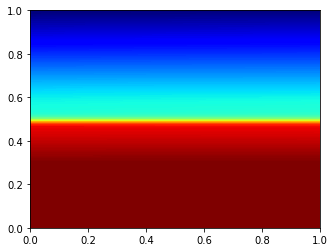

In [30]:
fig, ax = plt.subplots(1,1)
cmap = plt.cm.jet

img3 = ax.imshow(u_pred_3d[:,:,50],vmax =100,vmin=0,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)


In [29]:
np.min(u_pred_3d[:,:,0])

32.85324

In [ ]:
a = 0
for i in range(10):
    a = a + test_loss_full[i][-1]
print(a/10)

In [ ]:
a = 0
for i in range(10):
    a = a + train_loss_full[i][-1]
print(a/10)